# Variational Quantum Circuit Classifier 
### Task: Train a quantum circuit on labelled samples to predict labels for new data

Step 1: Encode the classical data into a quantum state

Step 2: Apply parameterized model 

Step 3: Measure the circuit to extract labels

Step 4: Use optimization techniques to update model parameters

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService,SamplerV2 as Sampler
 
 
 


from qiskit_machine_learning.datasets import ad_hoc_data
'''
importing data from the dataset
'''

# pylint: disable=unbalanced-tuple-unpacking
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=100,
                test_size=10,
                n=2,
                #two dimensional data
                gap=0.3,
                one_hot=False,
                
                )
)
import numpy as np


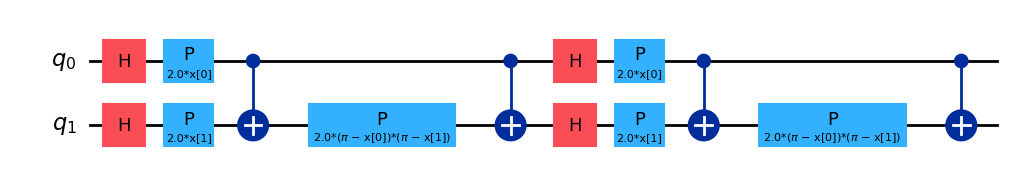

In [2]:


from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

#ZZFeatureMap maps classical data into a quantum state
FEATURE_MAP.decompose().draw('mpl') 


TwoLocal is an ansatz. It consists of parameterized single-qubit rotations and entangling states

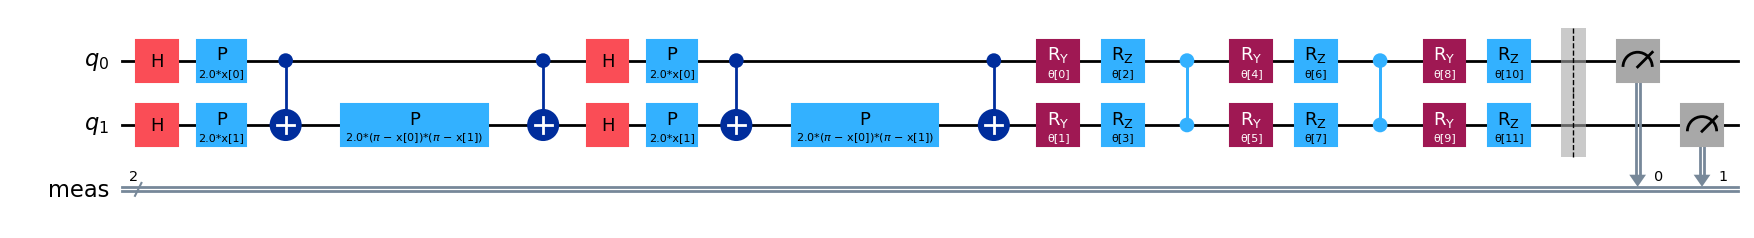

In [3]:
#composing the feature map and the variational form into a single quantum circuit
AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw('mpl')

The ZZFeatureMap is used as an encoder (classical information into quantum state)
- The ZZfeatureMap operate on qubits. Each qubit represents a dimension(feature) of the data


The TwoLocal is a Variational Model
- it applies the rotation gates to each qubit about a certain axis. Each rotation is parameterized
trainable parameter (theta)
- we can increase the number of parameters by repeating the reps (increasing expressibility)


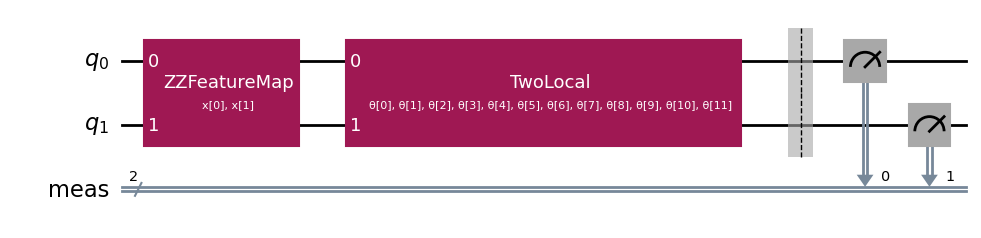

In [4]:
AD_HOC_CIRCUIT.draw('mpl')


In [5]:
def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
        - These parameters will be adjust during training to minimize the cost function
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    parameters = {}
    #create an empty dictionary 
    
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

In [6]:
def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""

    '''
    for example:
     
    bitstring = '0011' (this is the case for 4 dimensional data -> length of bitstring = 4)
    hamming_weight = 2 (even)
    return (2+1) % 2 = 1

    bitstring = '0111'
    hamming_weight = 3 (odd)
    return (3+1) % 2 = 0 
    
    '''
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

In [7]:
def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    '''probabilities = {0: 0, 1: 0}
    for bitstring, prob in quasi_probs.items():
        label = parity(bitstring)
        probabilities[label] += prob'''
    return probabilities

In [8]:
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    
    backend = Aer.get_backend('qasm_simulator')
    circuits = [transpile(circuit_instance(d, variational), backend, basis_gates=['u1', 'u2', 'u3', 'cx', 'id']) for d in data]
    results = backend.run(circuits).result()
    classification = [label_probability(results.get_counts(c)) for c in circuits]
    
    
    '''service = QiskitRuntimeService(channel="ibm_quantum", token="")
    backend = service.least_busy(operational=True, simulator=False)
    
    # Transpile circuits to match backend's supported gates
    circuits = [transpile(circuit_instance(d, variational), backend) for d in data]
    
    # Run circuits using the Qiskit Runtime Sampler
    sampler = Sampler(backend)
    results = sampler.run(circuits).result()
    # Process the results to determine classification probabilities
    classification = []
    for quasi_dist in results.quasi_dists:
        quasi_probs = quasi_dist.binary_probabilities()
        classification.append(label_probability(quasi_probs))
'''
    '''service = QiskitRuntimeService(channel="ibm_quantum", token="")
    backend = service.least_busy(operational=True, simulator=False)
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    circuits = [pm.run(circuit_instance(d,variational)) for d in data]
    sampler = Sampler(backend)
    results = sampler.run(circuits).result()
    classification = []
    for i in range(len(circuits)):
        quasi_probs = results.quasi_dists[i].binary_probabilities()
        classification.append(label_probability(quasi_probs))'''
  
    return classification

In [9]:
def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    # pylint: disable=invalid-name
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    # pylint: disable=invalid-name
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

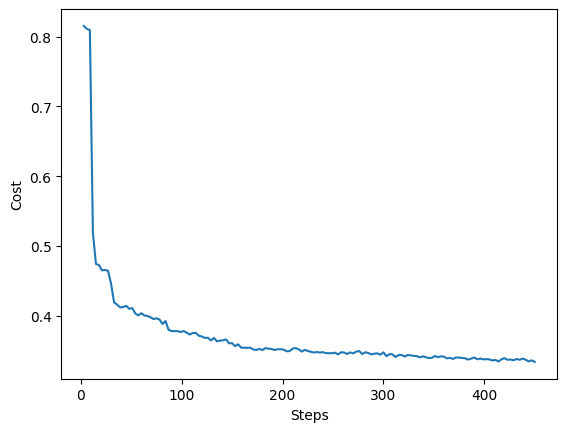

In [10]:
class OptimizerLog:  # pylint: disable=too-few-public-methods
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

# Set up the optimization
from qiskit_algorithms.optimizers import SPSA
log = OptimizerLog()
optimizer = SPSA(maxiter=150, callback=log.update)
np.random.seed(3142)
initial_point = np.random.random(VAR_FORM.num_parameters)
'''initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])
'''
def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [11]:
def test_classifier(data, labels, variational):
    """Gets classifier's most likely predictions and accuracy of those
    predictions.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): List of parameter values for classifier

    Returns:
        float: Average accuracy of classifier over `data`
        list: Classifier's label predictions for each data point
    """
    probability = classification_probability(data, variational)
    predictions = [0 if p[0] >= p[1] else 1 for p in probability]
    accuracy = 0
    # pylint: disable=invalid-name
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions

accuracy, predictions = test_classifier(TEST_DATA, TEST_LABELS, opt_var)
accuracy

1.0

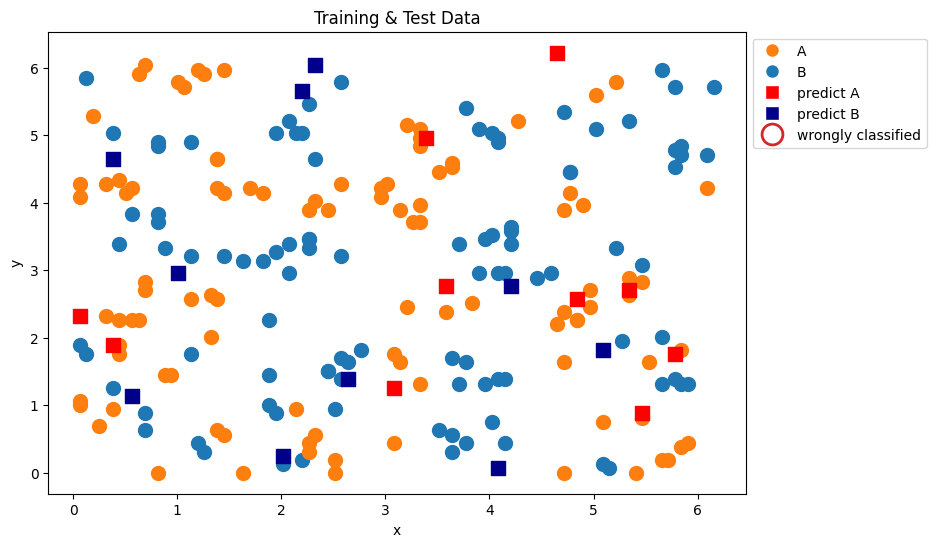

In [12]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(TRAIN_DATA, TRAIN_LABELS):
    COLOR = 'C0' if label == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='o', s=100, color=COLOR)

for feature, label, pred in zip(TEST_DATA, TEST_LABELS, predictions):
    COLOR = 'darkblue' if pred == 0 else 'red'
    plt.scatter(feature[0], feature[1],
                marker='s', s=100, color=COLOR)
    if label != pred:  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='red', label='predict A', ms=10),  # Changed to red
    Line2D([0], [0], marker='s', c='w', mfc='darkblue', label='predict B', ms=10),  # Changed to dark blue
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [13]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(TRAIN_LABELS.reshape(-1, 1)
                                       ).toarray()
test_labels_oh = encoder.fit_transform(TEST_LABELS.reshape(-1, 1)
                                      ).toarray()

In [14]:
#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([0.3200227 , 0.6503638 , 0.55995053,
                          0.96566328, 0.38243769, 0.90403094,
                          0.82271449, 0.26810137, 0.61076489,
                          0.82301609, 0.11789148, 0.29667125])

from qiskit_machine_learning.algorithms.classifiers import VQC
log = OptimizerLog()
vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=log.update),
          initial_point=initial_point,
          )

vqc.fit(TRAIN_DATA, train_labels_oh)

In [15]:
vqc.score(TEST_DATA, test_labels_oh)

0.95

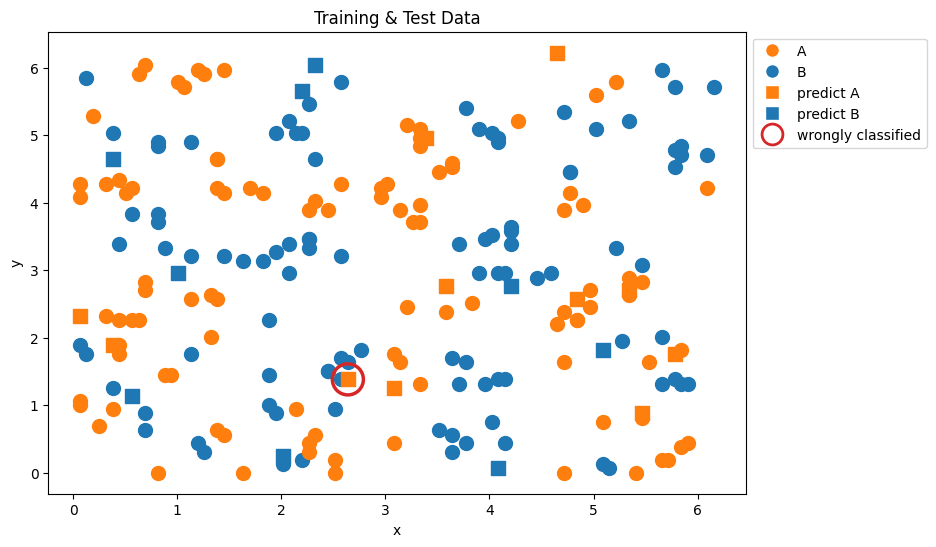

In [16]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(TRAIN_DATA, train_labels_oh):
    COLOR = 'C1' if label[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='o', s=100,
                color=COLOR)

for feature, label, pred in zip(TEST_DATA, test_labels_oh,
                                vqc.predict(TEST_DATA)):
    COLOR = 'C1' if pred[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='s', s=100, color=COLOR)
    if not np.array_equal(label,pred):  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()